<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:03:56] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


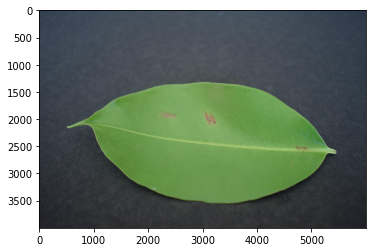

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

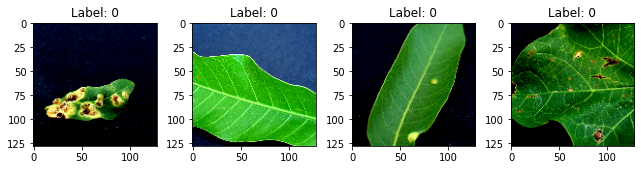

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:04:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:04:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2518007694853148 samples/sec                   batch loss = 0.5235515236854553 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.269049855687811 samples/sec                   batch loss = 0.8191754817962646 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2718253935163741 samples/sec                   batch loss = 0.9506746530532837 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2742672943461828 samples/sec                   batch loss = 0.9974534511566162 | accuracy = 0.425


Epoch[1] Batch[25] Speed: 1.2749835071983546 samples/sec                   batch loss = 1.2478808164596558 | accuracy = 0.47


Epoch[1] Batch[30] Speed: 1.272135340051646 samples/sec                   batch loss = 0.6556566953659058 | accuracy = 0.4583333333333333


Epoch[1] Batch[35] Speed: 1.2704128762187632 samples/sec                   batch loss = 0.576689600944519 | accuracy = 0.4714285714285714


Epoch[1] Batch[40] Speed: 1.276533922898709 samples/sec                   batch loss = 0.5405188202857971 | accuracy = 0.46875


Epoch[1] Batch[45] Speed: 1.2688389951245205 samples/sec                   batch loss = 0.7422114014625549 | accuracy = 0.48333333333333334


Epoch[1] Batch[50] Speed: 1.2725098110631308 samples/sec                   batch loss = 0.4910372793674469 | accuracy = 0.505


Epoch[1] Batch[55] Speed: 1.263555234283788 samples/sec                   batch loss = 0.7450888156890869 | accuracy = 0.5227272727272727


Epoch[1] Batch[60] Speed: 1.2703708387126085 samples/sec                   batch loss = 0.4081799387931824 | accuracy = 0.5375


Epoch[1] Batch[65] Speed: 1.267225264839646 samples/sec                   batch loss = 0.8204681277275085 | accuracy = 0.5423076923076923


Epoch[1] Batch[70] Speed: 1.2681203692792744 samples/sec                   batch loss = 1.2821153402328491 | accuracy = 0.5464285714285714


Epoch[1] Batch[75] Speed: 1.2711984404853116 samples/sec                   batch loss = 0.7550548911094666 | accuracy = 0.5533333333333333


Epoch[1] Batch[80] Speed: 1.2654024772063424 samples/sec                   batch loss = 0.750483512878418 | accuracy = 0.559375


Epoch[1] Batch[85] Speed: 1.2749182051370707 samples/sec                   batch loss = 0.6433738470077515 | accuracy = 0.5558823529411765


Epoch[1] Batch[90] Speed: 1.2723958350713493 samples/sec                   batch loss = 0.7467560172080994 | accuracy = 0.5638888888888889


Epoch[1] Batch[95] Speed: 1.2725492876106403 samples/sec                   batch loss = 0.4450083076953888 | accuracy = 0.5710526315789474


Epoch[1] Batch[100] Speed: 1.275430725055205 samples/sec                   batch loss = 0.7078747153282166 | accuracy = 0.57


Epoch[1] Batch[105] Speed: 1.2645798290317922 samples/sec                   batch loss = 0.6644952893257141 | accuracy = 0.5738095238095238


Epoch[1] Batch[110] Speed: 1.267893144970836 samples/sec                   batch loss = 0.5029897689819336 | accuracy = 0.5727272727272728


Epoch[1] Batch[115] Speed: 1.2786166334168636 samples/sec                   batch loss = 0.6064739227294922 | accuracy = 0.5760869565217391


Epoch[1] Batch[120] Speed: 1.2720975289006646 samples/sec                   batch loss = 0.4394107162952423 | accuracy = 0.575


Epoch[1] Batch[125] Speed: 1.2677375562396866 samples/sec                   batch loss = 0.5679758191108704 | accuracy = 0.574


Epoch[1] Batch[130] Speed: 1.2706621763496133 samples/sec                   batch loss = 0.6120381951332092 | accuracy = 0.5769230769230769


Epoch[1] Batch[135] Speed: 1.2707692004717321 samples/sec                   batch loss = 0.48224982619285583 | accuracy = 0.5851851851851851


Epoch[1] Batch[140] Speed: 1.273037879844436 samples/sec                   batch loss = 0.48017311096191406 | accuracy = 0.5946428571428571


Epoch[1] Batch[145] Speed: 1.27260247382483 samples/sec                   batch loss = 0.6585584878921509 | accuracy = 0.5913793103448276


Epoch[1] Batch[150] Speed: 1.2761829014230812 samples/sec                   batch loss = 0.6496586203575134 | accuracy = 0.5933333333333334


Epoch[1] Batch[155] Speed: 1.2640225627043782 samples/sec                   batch loss = 0.1511697620153427 | accuracy = 0.5967741935483871


Epoch[1] Batch[160] Speed: 1.2700654048388287 samples/sec                   batch loss = 0.37066078186035156 | accuracy = 0.6015625


Epoch[1] Batch[165] Speed: 1.2684387736108254 samples/sec                   batch loss = 0.7766693830490112 | accuracy = 0.6015151515151516


Epoch[1] Batch[170] Speed: 1.276625618396808 samples/sec                   batch loss = 0.9508135318756104 | accuracy = 0.5985294117647059


Epoch[1] Batch[175] Speed: 1.2731242432456304 samples/sec                   batch loss = 0.790385365486145 | accuracy = 0.6014285714285714


Epoch[1] Batch[180] Speed: 1.2693699755382535 samples/sec                   batch loss = 0.6308788061141968 | accuracy = 0.6013888888888889


Epoch[1] Batch[185] Speed: 1.2672634569568408 samples/sec                   batch loss = 0.6993171572685242 | accuracy = 0.6054054054054054


Epoch[1] Batch[190] Speed: 1.270442506155437 samples/sec                   batch loss = 0.29635196924209595 | accuracy = 0.6092105263157894


Epoch[1] Batch[195] Speed: 1.274511235374209 samples/sec                   batch loss = 0.7207239866256714 | accuracy = 0.6115384615384616


Epoch[1] Batch[200] Speed: 1.2715663848469618 samples/sec                   batch loss = 0.2217877060174942 | accuracy = 0.6175


Epoch[1] Batch[205] Speed: 1.2659936318555725 samples/sec                   batch loss = 0.48352962732315063 | accuracy = 0.624390243902439


Epoch[1] Batch[210] Speed: 1.2643009915482752 samples/sec                   batch loss = 0.18111148476600647 | accuracy = 0.6261904761904762


Epoch[1] Batch[215] Speed: 1.2697702083820708 samples/sec                   batch loss = 0.19212846457958221 | accuracy = 0.6267441860465116


Epoch[1] Batch[220] Speed: 1.272737051904958 samples/sec                   batch loss = 0.41934868693351746 | accuracy = 0.6295454545454545


Epoch[1] Batch[225] Speed: 1.2724205393956107 samples/sec                   batch loss = 0.5317062735557556 | accuracy = 0.6322222222222222


Epoch[1] Batch[230] Speed: 1.2658924728846184 samples/sec                   batch loss = 0.4148333668708801 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2611725694400855 samples/sec                   batch loss = 2.0222280025482178 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2622551228751209 samples/sec                   batch loss = 0.2973168194293976 | accuracy = 0.6375


Epoch[1] Batch[245] Speed: 1.262909312054121 samples/sec                   batch loss = 0.7272663116455078 | accuracy = 0.639795918367347


Epoch[1] Batch[250] Speed: 1.2648811040640633 samples/sec                   batch loss = 1.2899242639541626 | accuracy = 0.639


Epoch[1] Batch[255] Speed: 1.260994741200265 samples/sec                   batch loss = 0.2976759672164917 | accuracy = 0.6421568627450981


Epoch[1] Batch[260] Speed: 1.2584009954868562 samples/sec                   batch loss = 0.7286503314971924 | accuracy = 0.6423076923076924


Epoch[1] Batch[265] Speed: 1.255638005503421 samples/sec                   batch loss = 0.3854604959487915 | accuracy = 0.6415094339622641


Epoch[1] Batch[270] Speed: 1.2652628616307284 samples/sec                   batch loss = 0.36251088976860046 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.266660214033149 samples/sec                   batch loss = 0.31853100657463074 | accuracy = 0.649090909090909


Epoch[1] Batch[280] Speed: 1.2726735244152259 samples/sec                   batch loss = 0.6554250717163086 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2631301885960018 samples/sec                   batch loss = 0.7711779475212097 | accuracy = 0.6535087719298246


Epoch[1] Batch[290] Speed: 1.2667765124521841 samples/sec                   batch loss = 0.28695157170295715 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2731085926325014 samples/sec                   batch loss = 0.5051814317703247 | accuracy = 0.6550847457627119


Epoch[1] Batch[300] Speed: 1.2724395507982926 samples/sec                   batch loss = 0.5411987900733948 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.2681619704006628 samples/sec                   batch loss = 0.5682253241539001 | accuracy = 0.6557377049180327


Epoch[1] Batch[310] Speed: 1.26103189519522 samples/sec                   batch loss = 0.6876165866851807 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.2656878163141492 samples/sec                   batch loss = 0.729564905166626 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.2689062671000824 samples/sec                   batch loss = 0.6188414692878723 | accuracy = 0.65703125


Epoch[1] Batch[325] Speed: 1.2738970116463226 samples/sec                   batch loss = 0.38740989565849304 | accuracy = 0.6592307692307692


Epoch[1] Batch[330] Speed: 1.2740341856249302 samples/sec                   batch loss = 0.7376034259796143 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2603557888176622 samples/sec                   batch loss = 0.9671372175216675 | accuracy = 0.6597014925373135


Epoch[1] Batch[340] Speed: 1.2668090339227414 samples/sec                   batch loss = 0.511189341545105 | accuracy = 0.6610294117647059


Epoch[1] Batch[345] Speed: 1.2692165206182429 samples/sec                   batch loss = 0.7261672616004944 | accuracy = 0.6594202898550725


Epoch[1] Batch[350] Speed: 1.273109751923982 samples/sec                   batch loss = 0.6987829208374023 | accuracy = 0.6564285714285715


Epoch[1] Batch[355] Speed: 1.271990088051787 samples/sec                   batch loss = 0.3815716505050659 | accuracy = 0.6584507042253521


Epoch[1] Batch[360] Speed: 1.2708296501184462 samples/sec                   batch loss = 1.163761854171753 | accuracy = 0.6597222222222222


Epoch[1] Batch[365] Speed: 1.2709209130271617 samples/sec                   batch loss = 0.46523672342300415 | accuracy = 0.6589041095890411


Epoch[1] Batch[370] Speed: 1.27020540918682 samples/sec                   batch loss = 0.6178776621818542 | accuracy = 0.6574324324324324


Epoch[1] Batch[375] Speed: 1.2700599245271478 samples/sec                   batch loss = 1.0589560270309448 | accuracy = 0.6553333333333333


Epoch[1] Batch[380] Speed: 1.2696909295573917 samples/sec                   batch loss = 0.7077276706695557 | accuracy = 0.6552631578947369


Epoch[1] Batch[385] Speed: 1.2637361652349355 samples/sec                   batch loss = 0.3671528398990631 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2656761673009678 samples/sec                   batch loss = 0.5002062916755676 | accuracy = 0.6564102564102564


Epoch[1] Batch[395] Speed: 1.2644156183200665 samples/sec                   batch loss = 0.345743328332901 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.2659032662253027 samples/sec                   batch loss = 0.31793907284736633 | accuracy = 0.659375


Epoch[1] Batch[405] Speed: 1.270025024704496 samples/sec                   batch loss = 0.719245433807373 | accuracy = 0.6592592592592592


Epoch[1] Batch[410] Speed: 1.2660394882721746 samples/sec                   batch loss = 0.6138830184936523 | accuracy = 0.6579268292682927


Epoch[1] Batch[415] Speed: 1.2619035566689094 samples/sec                   batch loss = 0.9778282642364502 | accuracy = 0.6572289156626506


Epoch[1] Batch[420] Speed: 1.265381003222958 samples/sec                   batch loss = 0.6168989539146423 | accuracy = 0.656547619047619


Epoch[1] Batch[425] Speed: 1.2612391257395692 samples/sec                   batch loss = 0.49874207377433777 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2663334303494633 samples/sec                   batch loss = 0.30619028210639954 | accuracy = 0.6604651162790698


Epoch[1] Batch[435] Speed: 1.270121652876595 samples/sec                   batch loss = 0.588791012763977 | accuracy = 0.6609195402298851


Epoch[1] Batch[440] Speed: 1.2663766349008514 samples/sec                   batch loss = 0.47542604804039 | accuracy = 0.6613636363636364


Epoch[1] Batch[445] Speed: 1.2712151036928259 samples/sec                   batch loss = 0.4868047833442688 | accuracy = 0.6606741573033708


Epoch[1] Batch[450] Speed: 1.2663603850555547 samples/sec                   batch loss = 0.48241132497787476 | accuracy = 0.6627777777777778


Epoch[1] Batch[455] Speed: 1.2731181568503567 samples/sec                   batch loss = 0.3236243724822998 | accuracy = 0.6637362637362637


Epoch[1] Batch[460] Speed: 1.270486280181896 samples/sec                   batch loss = 0.5381297469139099 | accuracy = 0.6646739130434782


Epoch[1] Batch[465] Speed: 1.269856225091588 samples/sec                   batch loss = 0.528282105922699 | accuracy = 0.6655913978494624


Epoch[1] Batch[470] Speed: 1.2703691072502712 samples/sec                   batch loss = 0.684939980506897 | accuracy = 0.6670212765957447


Epoch[1] Batch[475] Speed: 1.26924734306534 samples/sec                   batch loss = 0.878790020942688 | accuracy = 0.6652631578947369


Epoch[1] Batch[480] Speed: 1.2690471679024533 samples/sec                   batch loss = 0.6839402914047241 | accuracy = 0.6666666666666666


Epoch[1] Batch[485] Speed: 1.2676909062237405 samples/sec                   batch loss = 0.4572167694568634 | accuracy = 0.6675257731958762


Epoch[1] Batch[490] Speed: 1.2621780140854755 samples/sec                   batch loss = 0.3513229489326477 | accuracy = 0.6688775510204081


Epoch[1] Batch[495] Speed: 1.2661948515732628 samples/sec                   batch loss = 0.6035622954368591 | accuracy = 0.6686868686868687


Epoch[1] Batch[500] Speed: 1.263572173542102 samples/sec                   batch loss = 0.5293989181518555 | accuracy = 0.669


Epoch[1] Batch[505] Speed: 1.2738301766384967 samples/sec                   batch loss = 0.4960894286632538 | accuracy = 0.6673267326732674


Epoch[1] Batch[510] Speed: 1.2711524985284233 samples/sec                   batch loss = 0.26011642813682556 | accuracy = 0.6676470588235294


Epoch[1] Batch[515] Speed: 1.2575379347770685 samples/sec                   batch loss = 0.5158001780509949 | accuracy = 0.6674757281553398


Epoch[1] Batch[520] Speed: 1.2664791141207017 samples/sec                   batch loss = 0.8727850914001465 | accuracy = 0.6673076923076923


Epoch[1] Batch[525] Speed: 1.2649708469329584 samples/sec                   batch loss = 0.342693030834198 | accuracy = 0.669047619047619


Epoch[1] Batch[530] Speed: 1.2662355619154575 samples/sec                   batch loss = 0.4458131194114685 | accuracy = 0.6683962264150943


Epoch[1] Batch[535] Speed: 1.2743273997143756 samples/sec                   batch loss = 0.33271560072898865 | accuracy = 0.6682242990654206


Epoch[1] Batch[540] Speed: 1.2649004630318996 samples/sec                   batch loss = 0.3508574962615967 | accuracy = 0.6694444444444444


Epoch[1] Batch[545] Speed: 1.2602024229947137 samples/sec                   batch loss = 0.6129244565963745 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.2664628616453373 samples/sec                   batch loss = 0.30684298276901245 | accuracy = 0.6718181818181819


Epoch[1] Batch[555] Speed: 1.2574450966306048 samples/sec                   batch loss = 0.48654457926750183 | accuracy = 0.6716216216216216


Epoch[1] Batch[560] Speed: 1.2670942422157256 samples/sec                   batch loss = 0.8776805996894836 | accuracy = 0.6723214285714286


Epoch[1] Batch[565] Speed: 1.2551885934549831 samples/sec                   batch loss = 0.535406768321991 | accuracy = 0.672566371681416


Epoch[1] Batch[570] Speed: 1.2554745115464827 samples/sec                   batch loss = 0.6450761556625366 | accuracy = 0.6723684210526316


Epoch[1] Batch[575] Speed: 1.2585122891463958 samples/sec                   batch loss = 0.38041481375694275 | accuracy = 0.6734782608695652


Epoch[1] Batch[580] Speed: 1.2619232042703707 samples/sec                   batch loss = 0.3969443738460541 | accuracy = 0.6737068965517241


Epoch[1] Batch[585] Speed: 1.2645530453839584 samples/sec                   batch loss = 0.8802593946456909 | accuracy = 0.6726495726495727


Epoch[1] Batch[590] Speed: 1.263009329225488 samples/sec                   batch loss = 0.4959352910518646 | accuracy = 0.6724576271186441


Epoch[1] Batch[595] Speed: 1.251763783866743 samples/sec                   batch loss = 0.587186872959137 | accuracy = 0.673109243697479


Epoch[1] Batch[600] Speed: 1.2645517109970112 samples/sec                   batch loss = 0.36376041173934937 | accuracy = 0.6741666666666667


Epoch[1] Batch[605] Speed: 1.2591190392903575 samples/sec                   batch loss = 0.7879496812820435 | accuracy = 0.6743801652892562


Epoch[1] Batch[610] Speed: 1.273607766197259 samples/sec                   batch loss = 0.45787593722343445 | accuracy = 0.675


Epoch[1] Batch[615] Speed: 1.2608306074056104 samples/sec                   batch loss = 0.6513805389404297 | accuracy = 0.6752032520325203


Epoch[1] Batch[620] Speed: 1.2598244693704472 samples/sec                   batch loss = 0.3024214208126068 | accuracy = 0.6745967741935484


Epoch[1] Batch[625] Speed: 1.2627928671524684 samples/sec                   batch loss = 0.7925906181335449 | accuracy = 0.6744


Epoch[1] Batch[630] Speed: 1.257422760970136 samples/sec                   batch loss = 0.3390718996524811 | accuracy = 0.6753968253968254


Epoch[1] Batch[635] Speed: 1.2612871985470688 samples/sec                   batch loss = 0.5802294611930847 | accuracy = 0.6751968503937008


Epoch[1] Batch[640] Speed: 1.2605649755888428 samples/sec                   batch loss = 0.3521784245967865 | accuracy = 0.676953125


Epoch[1] Batch[645] Speed: 1.2592338624694446 samples/sec                   batch loss = 0.7052313089370728 | accuracy = 0.6759689922480621


Epoch[1] Batch[650] Speed: 1.2583011405790105 samples/sec                   batch loss = 0.5418932437896729 | accuracy = 0.6757692307692308


Epoch[1] Batch[655] Speed: 1.270318223603567 samples/sec                   batch loss = 0.6707555651664734 | accuracy = 0.6755725190839694


Epoch[1] Batch[660] Speed: 1.264801862447086 samples/sec                   batch loss = 0.3645457327365875 | accuracy = 0.6761363636363636


Epoch[1] Batch[665] Speed: 1.2683124857357315 samples/sec                   batch loss = 0.5905588269233704 | accuracy = 0.6755639097744361


Epoch[1] Batch[670] Speed: 1.2639381914533203 samples/sec                   batch loss = 0.24985213577747345 | accuracy = 0.6753731343283582


Epoch[1] Batch[675] Speed: 1.2644951927642594 samples/sec                   batch loss = 0.8771877288818359 | accuracy = 0.6759259259259259


Epoch[1] Batch[680] Speed: 1.2786281320632016 samples/sec                   batch loss = 0.792915403842926 | accuracy = 0.6761029411764706


Epoch[1] Batch[685] Speed: 1.2762903721384158 samples/sec                   batch loss = 0.3572034537792206 | accuracy = 0.6773722627737226


Epoch[1] Batch[690] Speed: 1.2750924234401486 samples/sec                   batch loss = 0.6849533915519714 | accuracy = 0.677536231884058


Epoch[1] Batch[695] Speed: 1.2662515218483879 samples/sec                   batch loss = 0.5093783140182495 | accuracy = 0.676978417266187


Epoch[1] Batch[700] Speed: 1.2664693625854273 samples/sec                   batch loss = 0.5410929918289185 | accuracy = 0.6771428571428572


Epoch[1] Batch[705] Speed: 1.2682013693707423 samples/sec                   batch loss = 0.8271129727363586 | accuracy = 0.676241134751773


Epoch[1] Batch[710] Speed: 1.2731071435211199 samples/sec                   batch loss = 0.7051989436149597 | accuracy = 0.676056338028169


Epoch[1] Batch[715] Speed: 1.2758533209630565 samples/sec                   batch loss = 0.3918478786945343 | accuracy = 0.6772727272727272


Epoch[1] Batch[720] Speed: 1.2708233931206747 samples/sec                   batch loss = 0.4215583801269531 | accuracy = 0.6767361111111111


Epoch[1] Batch[725] Speed: 1.2639268602809637 samples/sec                   batch loss = 0.32677510380744934 | accuracy = 0.6772413793103448


Epoch[1] Batch[730] Speed: 1.2702542641213552 samples/sec                   batch loss = 0.4755159914493561 | accuracy = 0.6767123287671233


Epoch[1] Batch[735] Speed: 1.2725159881607553 samples/sec                   batch loss = 0.3961108922958374 | accuracy = 0.677891156462585


Epoch[1] Batch[740] Speed: 1.2736762216585638 samples/sec                   batch loss = 0.5209434628486633 | accuracy = 0.6777027027027027


Epoch[1] Batch[745] Speed: 1.2685856136818263 samples/sec                   batch loss = 0.9200685620307922 | accuracy = 0.6771812080536913


Epoch[1] Batch[750] Speed: 1.2744128733109232 samples/sec                   batch loss = 0.3493000566959381 | accuracy = 0.6773333333333333


Epoch[1] Batch[755] Speed: 1.267703358664154 samples/sec                   batch loss = 0.4662471115589142 | accuracy = 0.6768211920529801


Epoch[1] Batch[760] Speed: 1.2732058838550966 samples/sec                   batch loss = 0.3194701671600342 | accuracy = 0.6782894736842106


Epoch[1] Batch[765] Speed: 1.2744646664025145 samples/sec                   batch loss = 0.26910579204559326 | accuracy = 0.6803921568627451


Epoch[1] Batch[770] Speed: 1.2770357866841067 samples/sec                   batch loss = 0.35170140862464905 | accuracy = 0.6798701298701298


Epoch[1] Batch[775] Speed: 1.2710020787135385 samples/sec                   batch loss = 0.5390560626983643 | accuracy = 0.6796774193548387


Epoch[1] Batch[780] Speed: 1.2695226029925448 samples/sec                   batch loss = 0.4436730444431305 | accuracy = 0.6807692307692308


Epoch[1] Batch[785] Speed: 1.275041063819099 samples/sec                   batch loss = 0.3746992349624634 | accuracy = 0.6821656050955414


[Epoch 1] training: accuracy=0.6821065989847716
[Epoch 1] time cost: 648.1455352306366
[Epoch 1] validation: validation accuracy=0.7588888888888888


Epoch[2] Batch[5] Speed: 1.2587417351355483 samples/sec                   batch loss = 0.2612189054489136 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2626205681004454 samples/sec                   batch loss = 0.6546126008033752 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.257772683211346 samples/sec                   batch loss = 0.4590579569339752 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2693474063110806 samples/sec                   batch loss = 0.5054410099983215 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.267439515047638 samples/sec                   batch loss = 0.20802603662014008 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.266554358957131 samples/sec                   batch loss = 0.46765995025634766 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2676339154838994 samples/sec                   batch loss = 0.3759792745113373 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.274363697972476 samples/sec                   batch loss = 0.3860918879508972 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.2632378499346666 samples/sec                   batch loss = 0.5710457563400269 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2650934175421114 samples/sec                   batch loss = 0.36850234866142273 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2619778790770417 samples/sec                   batch loss = 0.3377125561237335 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.262441761339801 samples/sec                   batch loss = 0.513830304145813 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2695801479783047 samples/sec                   batch loss = 0.6836433410644531 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2699558075905093 samples/sec                   batch loss = 0.41557836532592773 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2683004048424458 samples/sec                   batch loss = 0.7175378799438477 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2677838264845904 samples/sec                   batch loss = 0.5613879561424255 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.260382489645945 samples/sec                   batch loss = 0.46015217900276184 | accuracy = 0.7176470588235294


Epoch[2] Batch[90] Speed: 1.2631506352300275 samples/sec                   batch loss = 1.067123293876648 | accuracy = 0.7222222222222222


Epoch[2] Batch[95] Speed: 1.264542846926636 samples/sec                   batch loss = 0.9645664691925049 | accuracy = 0.7210526315789474


Epoch[2] Batch[100] Speed: 1.2633584676458038 samples/sec                   batch loss = 0.516882598400116 | accuracy = 0.7175


Epoch[2] Batch[105] Speed: 1.2561322227421619 samples/sec                   batch loss = 0.7813381552696228 | accuracy = 0.7166666666666667


Epoch[2] Batch[110] Speed: 1.2554805243630953 samples/sec                   batch loss = 0.4937792718410492 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2600503247571353 samples/sec                   batch loss = 0.754359245300293 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.2657164623404975 samples/sec                   batch loss = 0.34782737493515015 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.260579466877249 samples/sec                   batch loss = 0.7867428064346313 | accuracy = 0.726


Epoch[2] Batch[130] Speed: 1.2536306400510144 samples/sec                   batch loss = 0.4469659924507141 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.2594289681298085 samples/sec                   batch loss = 0.21666018664836884 | accuracy = 0.7277777777777777


Epoch[2] Batch[140] Speed: 1.26770278393075 samples/sec                   batch loss = 0.8701539635658264 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2733626245216414 samples/sec                   batch loss = 0.6741045117378235 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.2688559803852835 samples/sec                   batch loss = 0.3917354643344879 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.267482890863324 samples/sec                   batch loss = 0.06199114769697189 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2564975183800744 samples/sec                   batch loss = 0.4861604869365692 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.257920648025108 samples/sec                   batch loss = 0.6360548734664917 | accuracy = 0.7424242424242424


Epoch[2] Batch[170] Speed: 1.2644633617847116 samples/sec                   batch loss = 1.2927536964416504 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2622534134648662 samples/sec                   batch loss = 0.2778260111808777 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.2606849886564608 samples/sec                   batch loss = 0.7171663045883179 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.24947558746641 samples/sec                   batch loss = 0.5571660399436951 | accuracy = 0.7418918918918919


Epoch[2] Batch[190] Speed: 1.2598003463298773 samples/sec                   batch loss = 0.5063073635101318 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2593684637839209 samples/sec                   batch loss = 0.7896735072135925 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.2620409128582388 samples/sec                   batch loss = 0.6504414081573486 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2673472196601647 samples/sec                   batch loss = 0.8516412377357483 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.2604139261136644 samples/sec                   batch loss = 0.19809596240520477 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.2612743977373884 samples/sec                   batch loss = 0.5725612044334412 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2601570830890028 samples/sec                   batch loss = 0.47122979164123535 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.262013097476751 samples/sec                   batch loss = 0.08805494010448456 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2643298606722966 samples/sec                   batch loss = 0.2483733594417572 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.264262310894354 samples/sec                   batch loss = 0.48785436153411865 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.2592352801704259 samples/sec                   batch loss = 0.3566942512989044 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2708652680485997 samples/sec                   batch loss = 0.5239235758781433 | accuracy = 0.7448979591836735


Epoch[2] Batch[250] Speed: 1.2627880197078802 samples/sec                   batch loss = 0.7834671139717102 | accuracy = 0.743


Epoch[2] Batch[255] Speed: 1.2689863118099072 samples/sec                   batch loss = 0.6847180724143982 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.257403159018943 samples/sec                   batch loss = 0.3890010118484497 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.257704889423173 samples/sec                   batch loss = 0.48940417170524597 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.2703264955257476 samples/sec                   batch loss = 0.30064108967781067 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2668974242374587 samples/sec                   batch loss = 0.5167985558509827 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.2742090333627027 samples/sec                   batch loss = 0.7457149028778076 | accuracy = 0.7428571428571429


Epoch[2] Batch[285] Speed: 1.2534875224421211 samples/sec                   batch loss = 0.5445839762687683 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.2652290836803612 samples/sec                   batch loss = 0.2821006178855896 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2623331908771886 samples/sec                   batch loss = 0.5872980952262878 | accuracy = 0.7432203389830508


Epoch[2] Batch[300] Speed: 1.2661411485066263 samples/sec                   batch loss = 0.878524124622345 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.267189180668548 samples/sec                   batch loss = 0.6823725700378418 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2611865058615062 samples/sec                   batch loss = 0.3682297468185425 | accuracy = 0.7411290322580645


Epoch[2] Batch[315] Speed: 1.2607252507234405 samples/sec                   batch loss = 0.6608794927597046 | accuracy = 0.7404761904761905


Epoch[2] Batch[320] Speed: 1.2676991439646261 samples/sec                   batch loss = 0.2939521074295044 | accuracy = 0.740625


Epoch[2] Batch[325] Speed: 1.2713886967217358 samples/sec                   batch loss = 0.28736746311187744 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2680421588923967 samples/sec                   batch loss = 0.24166235327720642 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2563716212092448 samples/sec                   batch loss = 0.5502537488937378 | accuracy = 0.7432835820895523


Epoch[2] Batch[340] Speed: 1.2580880816792128 samples/sec                   batch loss = 0.3966781497001648 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.266743323143594 samples/sec                   batch loss = 0.478728324174881 | accuracy = 0.744927536231884


Epoch[2] Batch[350] Speed: 1.2668229995372837 samples/sec                   batch loss = 0.4925280511379242 | accuracy = 0.7457142857142857


Epoch[2] Batch[355] Speed: 1.2654287241758415 samples/sec                   batch loss = 0.6420774459838867 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.2579324376687768 samples/sec                   batch loss = 0.4186429977416992 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.254079405668049 samples/sec                   batch loss = 0.23435455560684204 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2604463111027235 samples/sec                   batch loss = 0.2893001139163971 | accuracy = 0.7445945945945946


Epoch[2] Batch[375] Speed: 1.2660042358566388 samples/sec                   batch loss = 0.2342938482761383 | accuracy = 0.7466666666666667


Epoch[2] Batch[380] Speed: 1.2717541483840622 samples/sec                   batch loss = 0.4886873960494995 | accuracy = 0.7467105263157895


Epoch[2] Batch[385] Speed: 1.2684116344593148 samples/sec                   batch loss = 0.13860484957695007 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.2616473396293315 samples/sec                   batch loss = 0.2248631864786148 | accuracy = 0.7493589743589744


Epoch[2] Batch[395] Speed: 1.2629151110962566 samples/sec                   batch loss = 0.3063081204891205 | accuracy = 0.7493670886075949


Epoch[2] Batch[400] Speed: 1.267226700591881 samples/sec                   batch loss = 1.2911800146102905 | accuracy = 0.748125


Epoch[2] Batch[405] Speed: 1.271317404169537 samples/sec                   batch loss = 0.8187256455421448 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.2639688532913207 samples/sec                   batch loss = 0.7107240557670593 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2594923148460528 samples/sec                   batch loss = 0.13466531038284302 | accuracy = 0.7506024096385542


Epoch[2] Batch[420] Speed: 1.262313435530976 samples/sec                   batch loss = 0.20387457311153412 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2660413034903488 samples/sec                   batch loss = 0.4653468728065491 | accuracy = 0.7511764705882353


Epoch[2] Batch[430] Speed: 1.2608335447596533 samples/sec                   batch loss = 0.5121986865997314 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2649131468148906 samples/sec                   batch loss = 0.41231510043144226 | accuracy = 0.753448275862069


Epoch[2] Batch[440] Speed: 1.2606226585759033 samples/sec                   batch loss = 0.274049311876297 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2650021311810755 samples/sec                   batch loss = 0.5268795490264893 | accuracy = 0.7544943820224719


Epoch[2] Batch[450] Speed: 1.2656411260704006 samples/sec                   batch loss = 0.2203953117132187 | accuracy = 0.7561111111111111


Epoch[2] Batch[455] Speed: 1.2667071707749495 samples/sec                   batch loss = 0.23646777868270874 | accuracy = 0.7571428571428571


Epoch[2] Batch[460] Speed: 1.2623729883799524 samples/sec                   batch loss = 0.20593668520450592 | accuracy = 0.758695652173913


Epoch[2] Batch[465] Speed: 1.257343226074701 samples/sec                   batch loss = 0.51545649766922 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2551151624592758 samples/sec                   batch loss = 1.3303409814834595 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2637105595490983 samples/sec                   batch loss = 0.06203492358326912 | accuracy = 0.7605263157894737


Epoch[2] Batch[480] Speed: 1.2628579785936398 samples/sec                   batch loss = 0.7348089218139648 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.2662488459034167 samples/sec                   batch loss = 0.9105011820793152 | accuracy = 0.7582474226804123


Epoch[2] Batch[490] Speed: 1.2574177661841643 samples/sec                   batch loss = 0.41976311802864075 | accuracy = 0.7571428571428571


Epoch[2] Batch[495] Speed: 1.2577979545321303 samples/sec                   batch loss = 0.26953694224357605 | accuracy = 0.7575757575757576


Epoch[2] Batch[500] Speed: 1.2632641023019167 samples/sec                   batch loss = 0.6812951564788818 | accuracy = 0.7575


Epoch[2] Batch[505] Speed: 1.2635769318424366 samples/sec                   batch loss = 0.6473251581192017 | accuracy = 0.7589108910891089


Epoch[2] Batch[510] Speed: 1.2661314977266602 samples/sec                   batch loss = 0.3631012439727783 | accuracy = 0.7573529411764706


Epoch[2] Batch[515] Speed: 1.262023350102675 samples/sec                   batch loss = 0.553769588470459 | accuracy = 0.7572815533980582


Epoch[2] Batch[520] Speed: 1.2622581618381168 samples/sec                   batch loss = 0.43407198786735535 | accuracy = 0.75625


Epoch[2] Batch[525] Speed: 1.2680364085094071 samples/sec                   batch loss = 0.5174720287322998 | accuracy = 0.7566666666666667


Epoch[2] Batch[530] Speed: 1.2700251208446236 samples/sec                   batch loss = 0.1438932716846466 | accuracy = 0.7566037735849057


Epoch[2] Batch[535] Speed: 1.2655718131660771 samples/sec                   batch loss = 1.603968858718872 | accuracy = 0.7570093457943925


Epoch[2] Batch[540] Speed: 1.2615611981646728 samples/sec                   batch loss = 0.7948687672615051 | accuracy = 0.7560185185185185


Epoch[2] Batch[545] Speed: 1.2617005672728847 samples/sec                   batch loss = 0.16681437194347382 | accuracy = 0.7568807339449541


Epoch[2] Batch[550] Speed: 1.2661643683127144 samples/sec                   batch loss = 0.23144708573818207 | accuracy = 0.7572727272727273


Epoch[2] Batch[555] Speed: 1.264540082887097 samples/sec                   batch loss = 0.33465296030044556 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.2611106651139954 samples/sec                   batch loss = 0.4124281704425812 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2512594658980063 samples/sec                   batch loss = 0.34835413098335266 | accuracy = 0.7592920353982301


Epoch[2] Batch[570] Speed: 1.2603141302104006 samples/sec                   batch loss = 0.560068666934967 | accuracy = 0.7600877192982456


Epoch[2] Batch[575] Speed: 1.2631060338905875 samples/sec                   batch loss = 0.3367806673049927 | accuracy = 0.7613043478260869


Epoch[2] Batch[580] Speed: 1.2640911345458015 samples/sec                   batch loss = 0.2773746848106384 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.2706691054232038 samples/sec                   batch loss = 0.7848216891288757 | accuracy = 0.7611111111111111


Epoch[2] Batch[590] Speed: 1.2608887885154403 samples/sec                   batch loss = 0.42411649227142334 | accuracy = 0.7610169491525424


Epoch[2] Batch[595] Speed: 1.2547814508039563 samples/sec                   batch loss = 0.3380623161792755 | accuracy = 0.7600840336134453


Epoch[2] Batch[600] Speed: 1.2667571916633242 samples/sec                   batch loss = 1.4476351737976074 | accuracy = 0.76


Epoch[2] Batch[605] Speed: 1.262719494129939 samples/sec                   batch loss = 0.2449951320886612 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2689135609240465 samples/sec                   batch loss = 0.4792349636554718 | accuracy = 0.760655737704918


Epoch[2] Batch[615] Speed: 1.267373930324717 samples/sec                   batch loss = 0.2901356816291809 | accuracy = 0.7621951219512195


Epoch[2] Batch[620] Speed: 1.2633329723928741 samples/sec                   batch loss = 0.1823754459619522 | accuracy = 0.7629032258064516


Epoch[2] Batch[625] Speed: 1.2631202032711208 samples/sec                   batch loss = 0.6337577104568481 | accuracy = 0.7624


Epoch[2] Batch[630] Speed: 1.2649510089432099 samples/sec                   batch loss = 0.2791079580783844 | accuracy = 0.7626984126984127


Epoch[2] Batch[635] Speed: 1.2675021380371156 samples/sec                   batch loss = 0.41458559036254883 | accuracy = 0.7637795275590551


Epoch[2] Batch[640] Speed: 1.267787371135384 samples/sec                   batch loss = 0.2972486615180969 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.2564131136776746 samples/sec                   batch loss = 0.07786847651004791 | accuracy = 0.7631782945736434


Epoch[2] Batch[650] Speed: 1.2572712387075984 samples/sec                   batch loss = 0.386968731880188 | accuracy = 0.7626923076923077


Epoch[2] Batch[655] Speed: 1.2633610362544632 samples/sec                   batch loss = 0.32075878977775574 | accuracy = 0.7633587786259542


Epoch[2] Batch[660] Speed: 1.261057297655976 samples/sec                   batch loss = 0.3724907636642456 | accuracy = 0.7632575757575758


Epoch[2] Batch[665] Speed: 1.2602608301449127 samples/sec                   batch loss = 0.5637384057044983 | accuracy = 0.7635338345864662


Epoch[2] Batch[670] Speed: 1.258239234719606 samples/sec                   batch loss = 1.0192350149154663 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2615868116885036 samples/sec                   batch loss = 1.0232172012329102 | accuracy = 0.7614814814814815


Epoch[2] Batch[680] Speed: 1.2674168229229896 samples/sec                   batch loss = 0.27494192123413086 | accuracy = 0.7617647058823529


Epoch[2] Batch[685] Speed: 1.2660340426488832 samples/sec                   batch loss = 1.342461347579956 | accuracy = 0.762043795620438


Epoch[2] Batch[690] Speed: 1.265116694333433 samples/sec                   batch loss = 0.2707185447216034 | accuracy = 0.761231884057971


Epoch[2] Batch[695] Speed: 1.2597416034951843 samples/sec                   batch loss = 0.6093019843101501 | accuracy = 0.7607913669064749


Epoch[2] Batch[700] Speed: 1.263524021559086 samples/sec                   batch loss = 0.5099645853042603 | accuracy = 0.7607142857142857


Epoch[2] Batch[705] Speed: 1.2712348496776755 samples/sec                   batch loss = 0.6326298713684082 | accuracy = 0.7602836879432624


Epoch[2] Batch[710] Speed: 1.2606217113577871 samples/sec                   batch loss = 0.6107227802276611 | accuracy = 0.7595070422535212


Epoch[2] Batch[715] Speed: 1.2593669512497576 samples/sec                   batch loss = 0.39077651500701904 | accuracy = 0.7587412587412588


Epoch[2] Batch[720] Speed: 1.2534453801603003 samples/sec                   batch loss = 0.9140646457672119 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.2569502226549605 samples/sec                   batch loss = 0.4730471968650818 | accuracy = 0.7582758620689655


Epoch[2] Batch[730] Speed: 1.266748870515046 samples/sec                   batch loss = 0.07341529428958893 | accuracy = 0.7585616438356164


Epoch[2] Batch[735] Speed: 1.2644200018012308 samples/sec                   batch loss = 0.40253591537475586 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2672819316641917 samples/sec                   batch loss = 0.2717025876045227 | accuracy = 0.7597972972972973


Epoch[2] Batch[745] Speed: 1.258972965335053 samples/sec                   batch loss = 0.2988409101963043 | accuracy = 0.758724832214765


Epoch[2] Batch[750] Speed: 1.2602065879930906 samples/sec                   batch loss = 0.41268301010131836 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.2622541732021857 samples/sec                   batch loss = 0.3821685314178467 | accuracy = 0.7586092715231788


Epoch[2] Batch[760] Speed: 1.2599662936883012 samples/sec                   batch loss = 0.7040344476699829 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.263475302339263 samples/sec                   batch loss = 0.6656723618507385 | accuracy = 0.7568627450980392


Epoch[2] Batch[770] Speed: 1.2546771964364545 samples/sec                   batch loss = 0.48095977306365967 | accuracy = 0.7564935064935064


Epoch[2] Batch[775] Speed: 1.254620994473816 samples/sec                   batch loss = 0.21969632804393768 | accuracy = 0.7561290322580645


Epoch[2] Batch[780] Speed: 1.2603591973710464 samples/sec                   batch loss = 0.4440682530403137 | accuracy = 0.7560897435897436


Epoch[2] Batch[785] Speed: 1.2651065821795175 samples/sec                   batch loss = 0.6409860849380493 | accuracy = 0.756687898089172


[Epoch 2] training: accuracy=0.7566624365482234
[Epoch 2] time cost: 642.4454646110535
[Epoch 2] validation: validation accuracy=0.8111111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8177777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)